Damaging Classification
===

Messing around with understanding the revscoring approach.

I generated the data like so:
```
cat /export/scratch2/levon003/repos/wiki-ores-feedback/data/raw/editquality/datasets/enwiki.labeled_revisions.20k_2015.json | revscoring extract editquality.feature_lists.enwiki.damaging editquality.feature_lists.enwiki.goodfaith --host https://en.wikipedia.org --extractors 32 --verbose > enwiki.labeled_revisions.w_cache.20k_2015.json

revscoring dump_cache --input enwiki.labeled_revisions.w_cache.20k_2015.json --output enwiki.labeled_revisions.20k_2015.damaging.tsv --verbose editquality.feature_lists.enwiki.damaging damaging

```


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
import matplotlib.colors

In [2]:
import os
from collections import Counter

In [3]:
import sklearn
import sklearn.ensemble
import sklearn.metrics

In [4]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [5]:
editquality_data_dir = os.path.join(git_root_dir, "data", "raw", "editquality", "datasets")

In [6]:
df = pd.read_csv(os.path.join(editquality_data_dir, "enwiki.labeled_revisions.20k_2015.damaging.tsv"), sep='\t', header=0)
len(df)

19348

In [7]:
df.head()

,feature.revision.page.is_articleish,feature.revision.page.is_mainspace,feature.revision.page.is_draftspace,feature.log((wikitext.revision.parent.chars + 1)),feature.log((len(<datasource.tokenized(datasource.revision.parent.text)>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.words>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.uppercase_words>) + 1)),feature.log((wikitext.revision.parent.headings + 1)),feature.log((wikitext.revision.parent.wikilinks + 1)),feature.log((wikitext.revision.parent.external_links + 1)),...,feature.english.dictionary.revision.diff.dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.dict_word_prop_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_decrease,damaging
0,False,False,False,11.487669,9.673949,8.289037,2.890372,4.804021,5.924256,6.354370,...,2.597872,2.597872,0.0,12,12,0,11.027027,11.027027,0.0,False
1,True,True,False,9.782336,8.767173,7.884953,3.218876,2.639057,3.806662,0.693147,...,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
2,False,False,False,8.696009,7.963112,6.218600,1.098612,1.098612,4.304065,0.000000,...,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
3,True,True,False,9.205629,8.144969,7.152269,3.496508,1.945910,4.094345,2.564949,...,1.000000,1.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
4,False,False,False,7.603898,6.356108,5.323010,2.484907,0.693147,2.833213,0.693147,...,16.596429,16.596429,0.0,7,7,0,5.342857,5.342857,0.0,False


In [8]:
Counter(df.damaging).most_common()

[(False, 18599), (True, 749)]

In [9]:
# only 3.87% of the reverts in this set are damaging
np.sum(df.damaging) / len(df)

0.03871201157742402

### Use sklearn to train a classifier

Using basic cross-validation to evaluate it.

In [10]:
# shuffle the data
df = df.sample(frac=1)

In [11]:
# define the classifier based on the enwiki tuning report
# hyperparameters set from: https://github.com/wikimedia/editquality/blob/master/tuning_reports/enwiki.damaging.md
clf = sklearn.ensemble.GradientBoostingClassifier(
    learning_rate=0.01, 
    n_estimators=700, 
    max_features='log2', 
    max_depth=5
)

In [12]:
kf = sklearn.model_selection.KFold(n_splits=5)
train_accs = []
test_accs = []
roc_auc_list = []
for train_idx, test_idx in kf.split(df):
    train = df.loc[train_idx]
    test = df.loc[test_idx]
    
    # train the model
    md = clf.fit(train.iloc[:,:-1], train.iloc[:,-1])
    
    # predict with the model
    y_pred_train = md.predict(train.iloc[:,:-1])
    y_pred_test = md.predict(test.iloc[:,:-1])
    y_pred_test_proba = md.predict_proba(test.iloc[:,:-1])[:,1]
    
    # compute metrics
    acc_train = np.sum(y_pred_train == train.damaging) / len(y_pred_train)
    acc_test = np.sum(y_pred_test == test.damaging) / len(y_pred_test)
    roc_auc = sklearn.metrics.roc_auc_score(test.damaging, y_pred_test_proba)
    
    # save and print metrics
    train_accs.append(acc_train)
    test_accs.append(acc_test)
    roc_auc_list.append(roc_auc)
    print(f"Train: {acc_train*100:.3f}%; test: {acc_test*100:.3f}%; test ROC AUC: {roc_auc:.4f}")
print(f"CV train accuracy: {np.mean(train_accs)*100:.3f}%; CV test accuracy: {np.mean(test_accs)*100:.3f}%; test ROC AUC: {np.mean(roc_auc_list):.4f}")

Train: 97.635%; test: 96.408%; test ROC AUC: 0.9120
Train: 97.442%; test: 96.899%; test ROC AUC: 0.9439
Train: 97.519%; test: 96.796%; test ROC AUC: 0.9226
Train: 97.435%; test: 96.898%; test ROC AUC: 0.9336
Train: 97.571%; test: 96.666%; test ROC AUC: 0.9417
CV train accuracy: 97.520%; CV test accuracy: 96.734%; test ROC AUC: 0.9308


#### Results:

Dataset: 20k_2015 labeled revisions (n=19348)

5-fold Cross Validation:
 - 96.759% test accuracy
 - Test ROC AUC: 0.9302

The damaging model reported in the model tuning report [here](https://github.com/wikimedia/editquality/blob/master/tuning_reports/enwiki.damaging.md) reports an "roc_auc.labels.true" score of 0.9189. (n=19446)


#### Old results using a buggy ROC AUC computation (but correct accuracy):

20-fold Cross Validation:
 - 96.754% test accuracy
 - Test ROC AUC: 0.6053
 
5-fold Cross Validation:
 - 96.515% test accuracy
 - Test ROC AUC: 0.6074


In [13]:
# this is the classification report on the test data for the last fold
# recall on damaging edits is terrible
print(sklearn.metrics.classification_report(y_pred_test, test.damaging))

              precision    recall  f1-score   support

       False       1.00      0.97      0.98      3827
        True       0.20      0.67      0.30        42

   micro avg       0.97      0.97      0.97      3869
   macro avg       0.60      0.82      0.64      3869
weighted avg       0.99      0.97      0.98      3869



### Plotting the distribution of predictions

On the last fold of cross validation

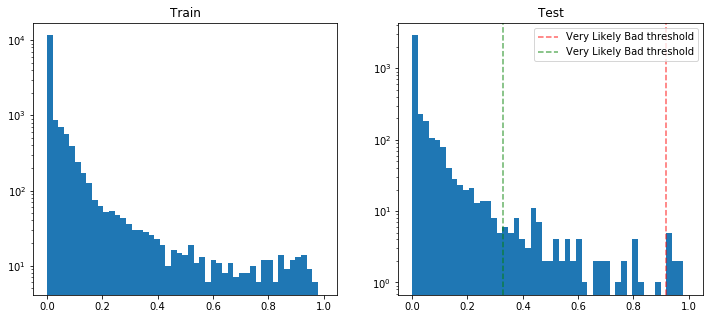

In [19]:
y_pred_train_proba = md.predict_proba(train.iloc[:,:-1])[:,1]
y_pred_test_proba = md.predict_proba(test.iloc[:,:-1])[:,1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

bins = np.linspace(0, 1, num=50)

ax = axes[0]
ax.hist(y_pred_train_proba, bins=bins, log=True)
ax.set_title("Train")

ax = axes[1]
ax.hist(y_pred_test_proba, bins=bins, log=True)
ax.set_title("Test")
plt.axvline(0.919, color='red', alpha=0.6, linestyle='--', label='Very Likely Bad threshold')
plt.axvline(0.329, color='green', alpha=0.6, linestyle='--', label='Likely Good threshold')
plt.legend()

plt.show()

In [23]:
train.columns

Index(['feature.revision.page.is_articleish',
       'feature.revision.page.is_mainspace',
       'feature.revision.page.is_draftspace',
       'feature.log((wikitext.revision.parent.chars + 1))',
       'feature.log((len(<datasource.tokenized(datasource.revision.parent.text)>) + 1))',
       'feature.log((len(<datasource.wikitext.revision.parent.words>) + 1))',
       'feature.log((len(<datasource.wikitext.revision.parent.uppercase_words>) + 1))',
       'feature.log((wikitext.revision.parent.headings + 1))',
       'feature.log((wikitext.revision.parent.wikilinks + 1))',
       'feature.log((wikitext.revision.parent.external_links + 1))',
       'feature.log((wikitext.revision.parent.templates + 1))',
       'feature.log((wikitext.revision.parent.ref_tags + 1))',
       'feature.revision.parent.chars_per_word',
       'feature.revision.parent.words_per_token',
       'feature.revision.parent.uppercase_words_per_word',
       'feature.revision.parent.markups_per_token',
       'featur

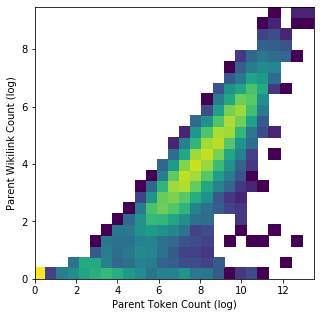

In [36]:
x = train['feature.log((len(<datasource.tokenized(datasource.revision.parent.text)>) + 1))']
y = train['feature.log((wikitext.revision.parent.wikilinks + 1))']
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plt.hist2d(x, y, bins=25, norm=matplotlib.colors.LogNorm())
plt.xlabel("Parent Token Count (log)")
plt.ylabel("Parent Wikilink Count (log)")
plt.show()